In [1]:
import dotenv

dotenv.load_dotenv()

True

In [2]:
project_names = [
    "gender_female",
    "gender_male",
    "language_de",
    "language_en",
    "language_es",
    "language_fr",
    "language_it",
    "language_ja",
    "language_pt",
    "singer_age_decade_10",
    "singer_age_decade_20",
    "singer_age_decade_30",
    "singer_age_decade_40",
    "singer_age_decade_50",
    "singer_age_decade_60",
    "singer_age_decade_70",
    "singer_age_decade_80",
]
encoder_ids = ["mert_v1_95m"]  # , "whisper_large_v2"]
target_columns = ["genre"]

In [3]:
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
from cavmir.evaluation import calculate_tcav_score
from cavmir.utils import load_embeddings

s3 = s3fs.S3FileSystem()

trainings_prefix = os.environ["TRAININGS_PREFIX"]
dataset_prefix = os.environ["DATASET_PREFIX"]
embedding_prefix = os.environ["EMBEDDING_PREFIX"]


def get_test_set(project_name: str):
    df_test = pd.read_csv(
        os.path.join(dataset_prefix, f"test_dataset_{project_name}.csv")
    )
    return df_test


### Use Case 1: Sort Audio Samples by CAV vector


In [4]:
# todo

### Use Case 2: Measuring Model Bias Using TCAV


In [ ]:
from collections import defaultdict
from matplotlib.patches import Patch
from scipy.stats import ttest_1samp


def calculate_tcav_scores(
    cav_vectors: np.ndarray,
    df: pd.DataFrame,
    target_column: str,
    embedding_prefix: str,
    encoder_id: str,
) -> dict[str, list[float]]:
    """
    Calculates the TCAV scores for each target label in the dataset.

    """
    target_labels = df[target_column].unique()

    tcav_scores = defaultdict(list)
    for target_label in target_labels:
        df_subset = df[df[target_column] == target_label]
        target_embeddings = load_embeddings(
            df_subset.song_id, embedding_prefix, encoder_id, s3
        )
        for cav_vector in cav_vectors:
            tcav_scores[target_label].append(
                calculate_tcav_score(cav_vector, target_embeddings)
            )

    return tcav_scores


def t_test_on_tcav_scores(
    tcav_scores: dict[str, list[float]],
    target_p_value: float = 0.05,
    bonferroni_correction: bool = True,
    verbose: bool = True,
) -> tuple[dict[str, float], float]:
    """
    Performs a t-test on the TCAV scores of each trained cav vector per target label.
    The null hypothesis is that the TCAV scores do not diverge from 0.5 (no bias).

    Parameters
    ----------
    tcav_scores : dict[str, list[float]]
        The TCAV scores per target label. Since we train mulitple cav vectors per target label, we expect a list of scores.
    target_p_value : float, optional
        The p-value threshold for the t-test, by default 0.05
    bonferroni_correction : bool, optional
        Whether to perform the Bonferroni correction on the p-values, by default True

    Returns
    -------
    pvalues : list[float]
        The p-values of the t-test for each target label.
    target_p_value : float
        The target p-value used for the t-test.
    """

    if bonferroni_correction:
        target_p_value_str = (
            f"({target_p_value} / {len(tcav_scores)}) (Bonferroni corrected)"
        )
        target_p_value = target_p_value / len(tcav_scores)
    else:
        target_p_value_str = f"{target_p_value}"

    p_values = {}
    for label, scores in tcav_scores.items():
        t_statistic, p_value = ttest_1samp(scores, 0.5)
        p_values[label] = p_value

        if not verbose:
            continue

        print(
            f"\nPerforming t-test on TCAV scores for label: {label}\nt-statistic: {t_statistic}"
        )

        if p_value < target_p_value:
            print(f"p-value: {p_value:.4e} < {target_p_value_str}")
            print("The null hypothesis (popmean=0.5) can be rejected.")
        else:
            print(f"p-value: {p_value:.4e} >= {target_p_value_str}")
            print("The null hypothesis (popmean=0.5) cannot be rejected.")

    return p_values, target_p_value


def plot_tcav_scores(
    tcav_scores: dict[str, list[float]],
    not_sigificant_labels: list[str],
    file_name: str | None = None,
):
    """
    Creates a relative bar plot of the TCAV scores for each target label.
    """

    colors = {
        "neutral": "#90A4AE",
        "positive": "#AED581",
        "negative": "#FF8A65",
    }

    tcav_scores = dict(
        sorted(tcav_scores.items(), key=lambda x: np.mean(x[1]), reverse=False)
    )

    plt.figure(figsize=(5, 4))
    labels = list(tcav_scores.keys())
    data = [scores for scores in tcav_scores.values()]

    box_colors = [
        colors["neutral"]
        if label in not_sigificant_labels
        else colors["positive"]
        if np.mean(scores) > 0.5
        else colors["negative"]
        for label, scores in zip(labels, data)
    ]

    boxprops = dict(linewidth=0.5)
    flierprops = dict(marker="o", color="gray", alpha=0.5, markersize=3)
    whiskerprops = dict(linewidth=0.5)
    capprops = dict(linewidth=0.5)
    medianprops = dict(linewidth=1.5, color="firebrick")
    meanprops = dict(
        marker="D", markeredgecolor="black", markerfacecolor="firebrick", markersize=3
    )

    bplot = plt.boxplot(
        data,
        vert=False,
        patch_artist=True,
        boxprops=boxprops,
        flierprops=flierprops,
        whiskerprops=whiskerprops,
        capprops=capprops,
        medianprops=medianprops,
        meanprops=meanprops,
        showmeans=True,
    )

    for patch, color in zip(bplot["boxes"], box_colors):
        patch.set_facecolor(color)

    plt.axvline(0.5, color="black", linewidth=0.5)
    plt.yticks(range(1, len(labels) + 1), labels)

    plt.yticks(rotation=0)
    plt.xticks(np.arange(0, 1.1, 0.25))
    plt.xlim(0, 1)

    plt.grid(axis="x", linestyle="--", linewidth=0.5)
    legend_elements = [
        Patch(facecolor=colors["positive"], label="Positive bias"),
        Patch(facecolor=colors["negative"], label="Negative bias"),
        Patch(facecolor=colors["neutral"], label="No significance"),
    ]
    plt.legend(handles=legend_elements, loc="lower right", fontsize="x-small")
    plt.tight_layout()

    if file_name:
        plt.savefig(file_name)
    plt.show()


def get_project_prefix(project_name: str) -> str:
    if project_name.startswith("singer_age"):
        return "singer_age"
    elif project_name.startswith("language"):
        return "language"
    elif project_name.startswith("gender"):
        return "gender"
    else:
        raise Exception


def run_evaluations(evaluation_variations: list[tuple]) -> dict[str, list[float]]:
    for project_name, encoder_id, target_column in evaluation_variations:
        print(f"Evaluating {project_name} with {encoder_id} on {target_column}")

        df_test = get_test_set(project_name)
        project_prefix = get_project_prefix(project_name)

        cav_vector_dir = os.path.join(
            trainings_prefix,
            encoder_id,
            project_prefix,
            "trainings",
            project_name,
            f"cav_ttest_{project_name}.npy",
        )

        cav_vector = np.load(cav_vector_dir)

        tcav_scores = calculate_tcav_scores(
            cav_vector, df_test, target_column, embedding_prefix, encoder_id
        )
        p_values, target_p_value = t_test_on_tcav_scores(tcav_scores, verbose=False)

        genres_to_accept_h0 = [
            genre for genre, p in p_values.items() if p >= target_p_value
        ]

        file_name = os.path.join(
            "plots",
            f"tcav_ttest_{encoder_id}_{project_name}_{target_column}.png",
        )

        plot_tcav_scores(tcav_scores, genres_to_accept_h0, file_name)


Evaluating gender_female with mert_v1_95m on genre


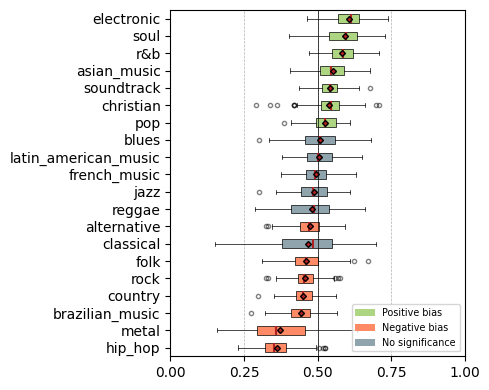

Evaluating gender_male with mert_v1_95m on genre


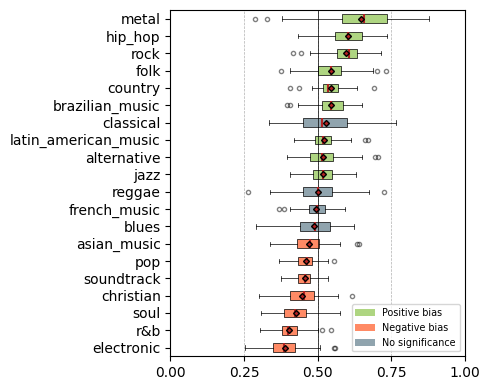

Evaluating language_de with mert_v1_95m on genre


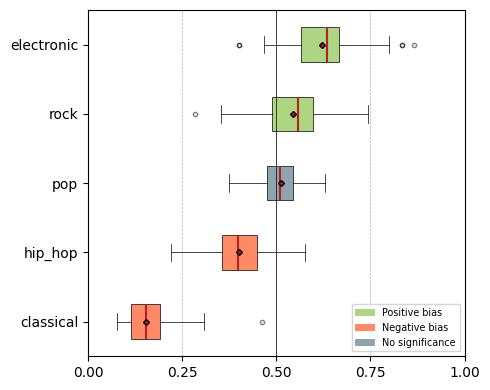

Evaluating language_en with mert_v1_95m on genre


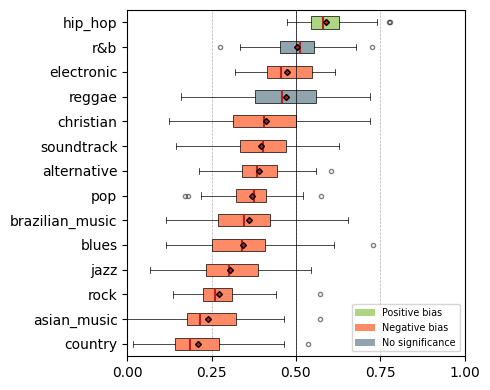

Evaluating language_es with mert_v1_95m on genre


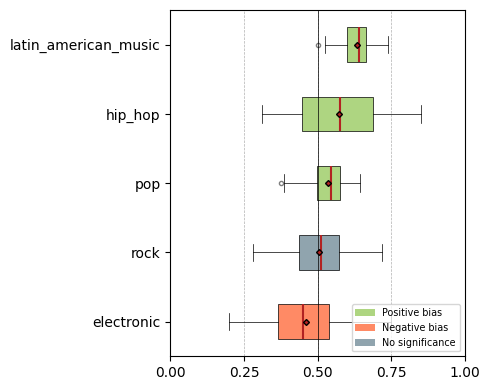

Evaluating language_fr with mert_v1_95m on genre


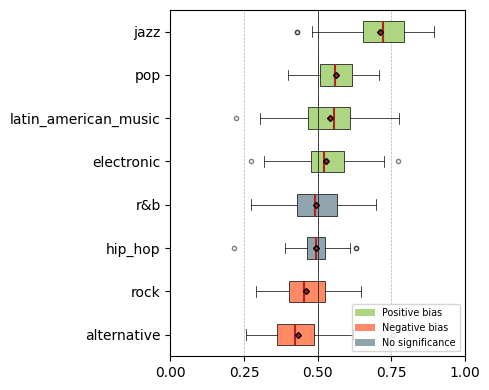

Evaluating language_it with mert_v1_95m on genre


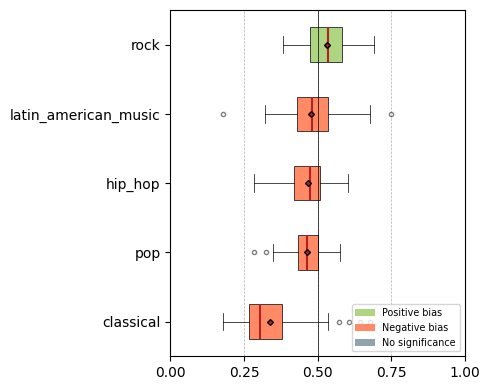

Evaluating language_ja with mert_v1_95m on genre


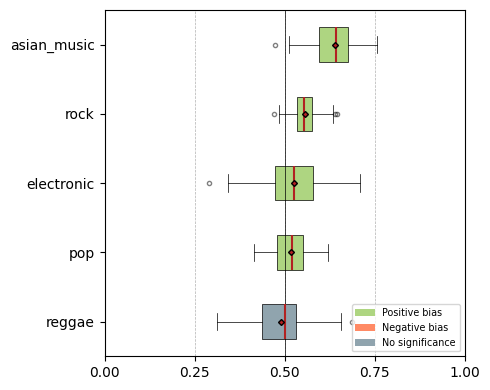

Evaluating language_pt with mert_v1_95m on genre


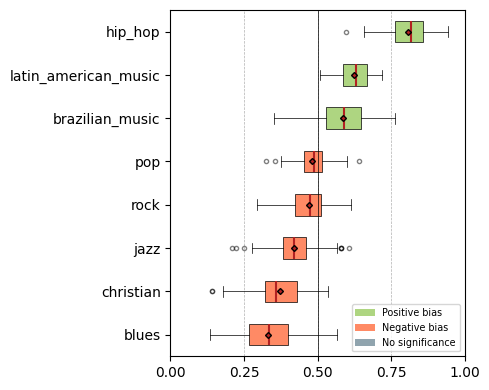

Evaluating singer_age_decade_10 with mert_v1_95m on genre


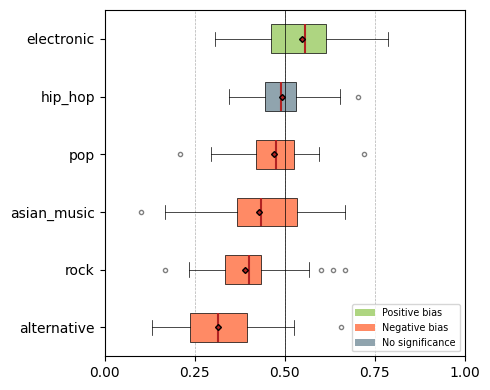

Evaluating singer_age_decade_20 with mert_v1_95m on genre


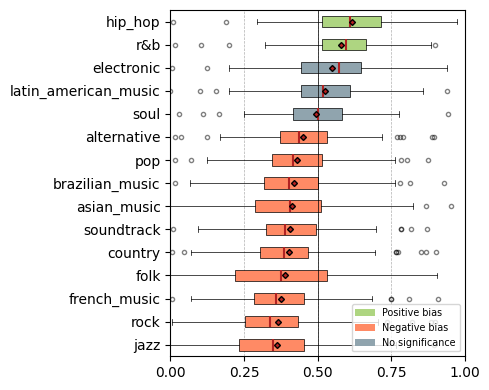

Evaluating singer_age_decade_30 with mert_v1_95m on genre


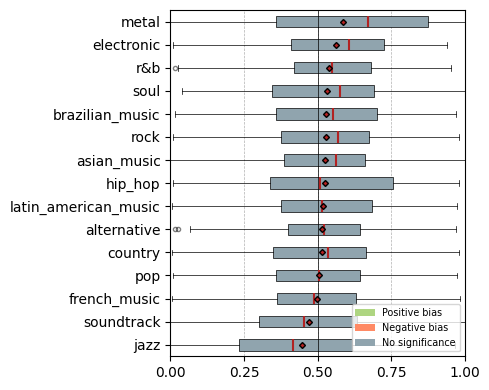

Evaluating singer_age_decade_40 with mert_v1_95m on genre


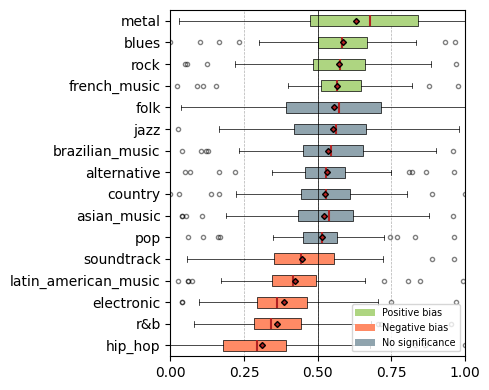

Evaluating singer_age_decade_50 with mert_v1_95m on genre


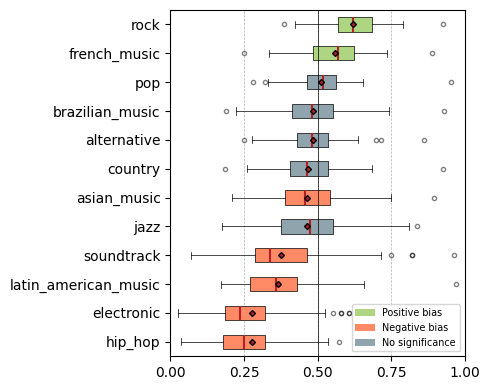

Evaluating singer_age_decade_60 with mert_v1_95m on genre


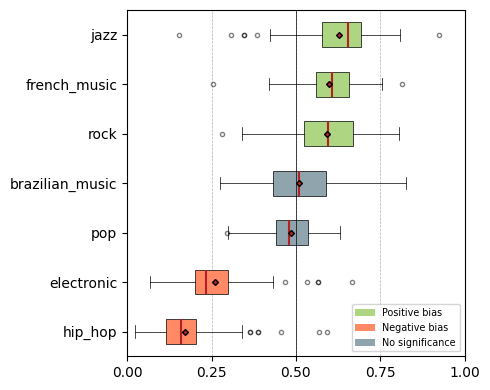

Evaluating singer_age_decade_70 with mert_v1_95m on genre


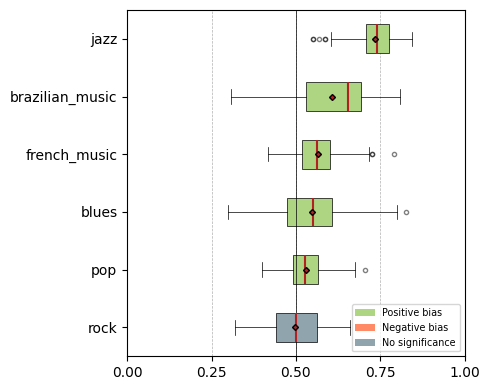

Evaluating singer_age_decade_80 with mert_v1_95m on genre


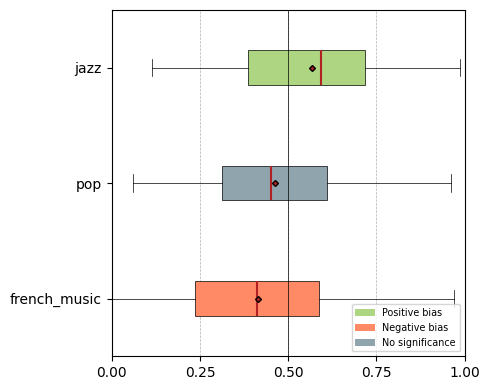

In [45]:
evaluation_variations = [*itertools.product(project_names, encoder_ids, target_columns)]

results = run_evaluations(evaluation_variations)